# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, recall_score,\
    accuracy_score, precision_score, f1_score, RocCurveDisplay

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, StackingClassifier,\
        BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from scipy.stats import uniform, truncnorm, randint

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipe

from src.model_handling import ModelStorer, SaveModel

from datetime import datetime

from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision

from tensorflow.keras.datasets import mnist

from scikeras.wrappers import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Non-image Data

In [88]:
df = pd.read_csv('./data/default.csv', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

Gender (1 = male; 2 = female).

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

Marital status (1 = married; 2 = single; 3 = others).

Age (year).

History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
- PAY_0 = the repayment status in September, 2005
- PAY_1 = the repayment status in August, 2005 . . .
- PAY_6 = the repayment status in April, 2005 

The measurement scale for the repayment status is: 
- -1 = pay ontime; 
- 1 = payment delay for one month
- 2 = payment delay for two months
- 8 = payment delay for eight months
- 9 = payment delay for nine months and above.

Amount of bill statement. 
- BILL_AMT1 = amount of bill statement in September, 2005
- BILL_AMT2 = amount of bill statement in August, 2005 . . .
- BILL_AMT6 = amount of bill statement in April, 2005

Amount of previous payment. 
- PAY_AMT1 = amount paid in September, 2005 
- PAY_AMT2 = amount paid in August, 2005 . . .
- PAY_AMT6 = amount paid in April, 2005



In [89]:
df.drop('ID', axis=1, inplace=True)

In [90]:
df.rename(columns = {'default payment next month':'default'}, inplace=True)

In [91]:
df.columns = [x.strip().lower() for x in df.columns]

In [92]:
df.describe()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  30000 non-null  int64
 1   sex        30000 non-null  int64
 2   education  30000 non-null  int64
 3   marriage   30000 non-null  int64
 4   age        30000 non-null  int64
 5   pay_0      30000 non-null  int64
 6   pay_2      30000 non-null  int64
 7   pay_3      30000 non-null  int64
 8   pay_4      30000 non-null  int64
 9   pay_5      30000 non-null  int64
 10  pay_6      30000 non-null  int64
 11  bill_amt1  30000 non-null  int64
 12  bill_amt2  30000 non-null  int64
 13  bill_amt3  30000 non-null  int64
 14  bill_amt4  30000 non-null  int64
 15  bill_amt5  30000 non-null  int64
 16  bill_amt6  30000 non-null  int64
 17  pay_amt1   30000 non-null  int64
 18  pay_amt2   30000 non-null  int64
 19  pay_amt3   30000 non-null  int64
 20  pay_amt4   30000 non-null  int64
 21  pay_amt5   3

In [94]:
X = df.drop(['default'], axis=1)
y = df['default']

In [95]:
# Create holdout/validation set
X_tt, X_val, y_tt, y_val = train_test_split(X, y, test_size=.17, random_state=42)

In [96]:
# Create Train Test Split for modeling
X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt, test_size=.2, random_state=42)

In [97]:
# Check Sizes:
print(f'Total Shape:   {X.shape}')
print(f'Train Shape:   {X_train.shape}')
print(f'Test Shape:    {X_test.shape}')
print(f'Holdout Shape: {X_val.shape}')

Total Shape:   (30000, 23)
Train Shape:   (19920, 23)
Test Shape:    (4980, 23)
Holdout Shape: (5100, 23)


In [98]:
# Check distributions
print(f'Total target: \n{y.value_counts(normalize=True)}\n')
print(f'Total train: \n{y_train.value_counts(normalize=True)}\n')
print(f'Total test: \n{y_test.value_counts(normalize=True)}\n')
print(f'Total valn: \n{y_val.value_counts(normalize=True)}\n')

Total target: 
0    0.7788
1    0.2212
Name: default, dtype: float64

Total train: 
0    0.778112
1    0.221888
Name: default, dtype: float64

Total test: 
0    0.782731
1    0.217269
Name: default, dtype: float64

Total valn: 
0    0.777647
1    0.222353
Name: default, dtype: float64



### Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [15]:
X.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [99]:
cat_features = ['sex','education','marriage']

In [100]:
num_features = list(X.drop(['sex','education','marriage','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'], axis=1).columns)
num_features

['limit_bal',
 'age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']

In [101]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())])

subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [102]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

CT = ColumnTransformer(transformers=[
        ('subpipe_num', subpipe_num, num_features),
        ('subpipe_cat', subpipe_cat, cat_features)], remainder='passthrough')

In [103]:
CT.fit_transform(X_train).shape

(19920, 33)

## Image Data

In [129]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

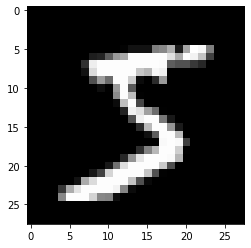

In [130]:
plt.imshow(X_train[0], cmap='gray')

In [131]:
np.max(X_train[0])

255

In [132]:
X = (np.vstack( (X_train.reshape(X_train.shape[0],-1), X_test.reshape(X_test.shape[0],-1)))) / 255

In [133]:
y = np.hstack( (y_train, y_test))
y = y % 2

In [134]:
X.shape

(70000, 784)

In [135]:
X = X[:10_000]
y = y[:10_000]

In [136]:
# Create holdout/validation set
X_tt, X_val, y_tt, y_val = train_test_split(X, y, test_size=.17, random_state=42)

In [137]:
# Create Train Test Split for modeling
X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt, test_size=.2, random_state=42)

In [138]:
# Check Sizes:
print(f'Total Shape:   {X.shape}')
print(f'Train Shape:   {X_train.shape}')
print(f'Test Shape:    {X_test.shape}')
print(f'Holdout Shape: {X_val.shape}')

Total Shape:   (10000, 784)
Train Shape:   (6639, 784)
Test Shape:    (1660, 784)
Holdout Shape: (1701, 784)


In [139]:
# Check distributions
print(f'Total target: \n{pd.Series(y).value_counts(normalize=True)}\n')
print(f'Total train: \n{pd.Series(y_train).value_counts(normalize=True)}\n')
print(f'Total test: \n{pd.Series(y_test).value_counts(normalize=True)}\n')
print(f'Total val: \n{pd.Series(y_val).value_counts(normalize=True)}\n')

Total target: 
1    0.507
0    0.493
dtype: float64

Total train: 
1    0.510619
0    0.489381
dtype: float64

Total test: 
1    0.501807
0    0.498193
dtype: float64

Total val: 
0    0.502058
1    0.497942
dtype: float64



## Dummy

In [16]:
# Baseline Step1 

# dummy_model_pipe = Pipeline(steps=[('ct', CT),
#                             ('dummy', DummyClassifier(strategy='most_frequent'))])

NameError: name 'CT' is not defined

In [17]:
# Data2
dummy_model_pipe = Pipeline(steps=[('dummy', DummyClassifier(strategy='most_frequent'))])

In [18]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('dummy', DummyClassifier(strategy='most_frequent'))])

In [19]:
model_dict = ModelStorer()

In [20]:
dummy_results = SaveModel(model=dummy_model_pipe, 
                          model_name='dummy',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [21]:
dummy_results.score_model_train_test()

In [22]:
model_dict.add_model(dummy_results)

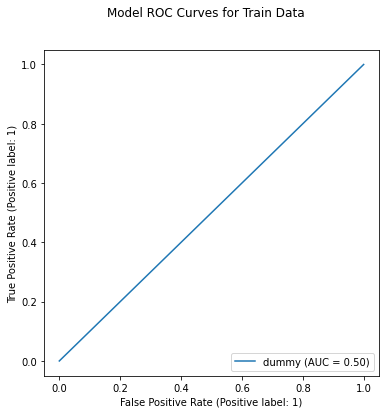

In [23]:
model_dict.plot_models_roc_curves()

In [24]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807


## FSM

In [ ]:
# Step 2
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.
# Upped max iter to get rid of error

fsm_pipe = Pipeline(steps=[('ct', CT),  
                            ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [25]:
fsm_pipe = Pipeline(steps=[('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [26]:
fsm_results = SaveModel(model=fsm_pipe, 
                          model_name='fsm',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [27]:
fsm_results.score_model_train_test()

In [28]:
model_dict.add_model(fsm_results)

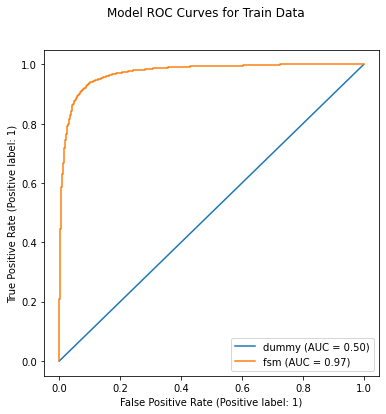

In [29]:
 model_dict.plot_models_roc_curves()

In [30]:
model_dict.print_scores()

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### kNN

In [ ]:
knn_pipe = Pipeline([('ct',CT),('knn',KNeighborsClassifier())])

In [31]:
knn_pipe = Pipeline([('knn',KNeighborsClassifier())])

In [32]:
knn_results = SaveModel(model=knn_pipe, 
                          model_name='knn',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [33]:
knn_results.score_model_train_test()

In [34]:
model_dict.add_model(knn_results)

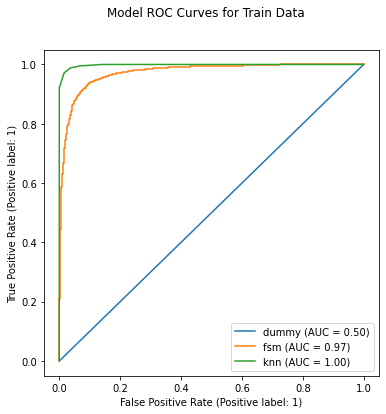

In [35]:
model_dict.plot_models_roc_curves()

In [36]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542
0,knn,train,accuracy_score,0.975900
4,knn,test,accuracy_score,0.971084


### Decision Tree

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_pipe = Pipeline([('ct', CT), ('dtc', dtc)])

In [37]:
dtc = DecisionTreeClassifier(random_state=42)
dtc_pipe = Pipeline([('dtc', dtc)])

In [38]:
dtc_results = SaveModel(model=dtc_pipe, 
                          model_name='dtc',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [39]:
dtc_results.score_model_train_test()

In [40]:
model_dict.add_model(dtc_results)

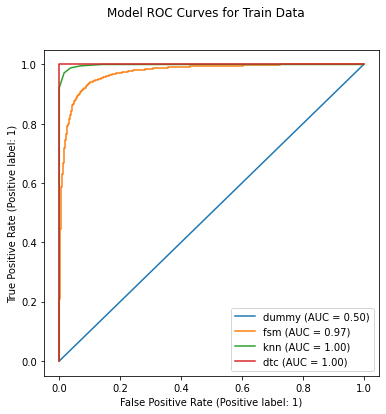

In [41]:
model_dict.plot_models_roc_curves()

In [42]:
model_dict.print_scores()

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542
0,knn,train,accuracy_score,0.975900
4,knn,test,accuracy_score,0.971084
0,dtc,train,accuracy_score,1.000000
4,dtc,test,accuracy_score,0.902410


### Let's do a bunch!

In [43]:
# Must be 'voting=soft' to work with roc

vc = VotingClassifier(estimators=[
    ('lr' , LogisticRegression(max_iter=1000, random_state=42)),
    ('dt' , DecisionTreeClassifier(random_state=42)),
    ('knn' , KNeighborsClassifier())
], verbose=True, voting='soft')

In [44]:
bag = BaggingClassifier(random_state=42, verbose=1)

In [45]:
rf = RandomForestClassifier(random_state=42, verbose=1)

In [46]:
et = ExtraTreesClassifier(bootstrap=True, random_state=42, verbose=1)

In [47]:
sc = StackingClassifier(estimators = [
    ('lr',LogisticRegression(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('bag', BaggingClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
], verbose=1)

In [48]:
model_list = [('voting',vc), ('bagging', bag), ('RandoCalForest',rf), ('ExtraTrees',et), ('stacking',sc)]

In [49]:
# Loop, fit, record.
# This was SHAMELESSLY stolen from Will Bennet from his Phase 3 project.

for name, model in model_list:

    starttime = datetime.now()
    
    print(f'Starting on model: {name}')
    # Create baseline pipelines
#     loop_model_pipe = Pipeline(steps=[
#         ('ct', CT),
#         (name, model)
#     ])
    
    loop_model_pipe = Pipeline(steps=[
        (name, model)
    ])

    # Create a saved model object
    loop_model_results = SaveModel(model=loop_model_pipe, 
                          model_name=name,
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)
    # Fit and score on train and test data
    loop_model_results.score_model_train_test()

    # Add the model to the dictionary
    model_dict.add_model(loop_model_results)
    
    print(f'{name} took {datetime.now()-starttime} to finish. \n')
    

Starting on model: voting
[Voting] ....................... (1 of 3) Processing lr, total=   1.6s
[Voting] ....................... (2 of 3) Processing dt, total=   1.3s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s
voting took 0:00:04.448001 to finish. 

Starting on model: bagging
bagging took 0:00:08.992001 to finish. 

Starting on model: RandoCalForest


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandoCalForest took 0:00:02.717998 to finish. 

Starting on model: ExtraTrees


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


ExtraTrees took 0:00:01.797000 to finish. 

Starting on model: stacking
stacking took 0:01:09.749000 to finish. 



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


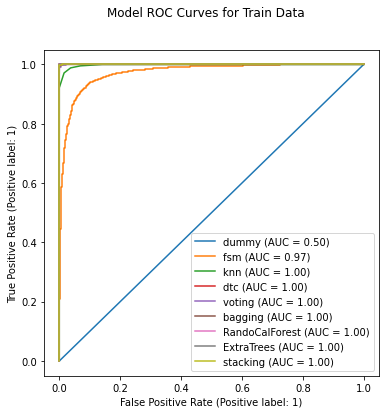

In [50]:
model_dict.plot_models_roc_curves()

In [51]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542
0,knn,train,accuracy_score,0.975900
4,knn,test,accuracy_score,0.971084
0,dtc,train,accuracy_score,1.000000
4,dtc,test,accuracy_score,0.902410
0,voting,train,accuracy_score,0.995180
4,voting,test,accuracy_score,0.949398


### Neural Network

In [140]:
X_train.shape

(6639, 784)

In [141]:
def build_model():
    model = Sequential()
    
#     model.add(Dense(12, activation='relu', input_dim=33))


    model.add(Input(784))
    
    model.add(Dense(12, activation='relu'))
    
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    

    return model

In [142]:
model = build_model()

In [143]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 12)                9420      
                                                                 
 dense_25 (Dense)            (None, 8)                 104       
                                                                 
 dense_26 (Dense)            (None, 4)                 36        
                                                                 
 dense_27 (Dense)            (None, 1)                 5         
                                                                 
Total params: 9,565
Trainable params: 9,565
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='loss', min_delta=1e-4,
                       verbose=1,
                       patience=5,
                       mode='min')

keras_model = KerasClassifier(build_model,
                              epochs=50,
                              batch_size=1024,
                              verbose=2,
                              callbacks = [early_stop])

In [145]:
nn_pipe = Pipeline([('nn', keras_model)])

In [146]:
nn_results = SaveModel(model=nn_pipe, 
                          model_name='nn',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [147]:
nn_results.score_model_train_test()

Epoch 1/50
7/7 - 1s - loss: 0.6861 - accuracy: 0.5180 - 877ms/epoch - 125ms/step
Epoch 2/50
7/7 - 0s - loss: 0.6626 - accuracy: 0.6067 - 106ms/epoch - 15ms/step
Epoch 3/50
7/7 - 0s - loss: 0.6304 - accuracy: 0.6927 - 78ms/epoch - 11ms/step
Epoch 4/50
7/7 - 0s - loss: 0.5975 - accuracy: 0.7262 - 73ms/epoch - 10ms/step
Epoch 5/50
7/7 - 0s - loss: 0.5667 - accuracy: 0.7593 - 85ms/epoch - 12ms/step
Epoch 6/50
7/7 - 0s - loss: 0.5392 - accuracy: 0.7848 - 107ms/epoch - 15ms/step
Epoch 7/50
7/7 - 0s - loss: 0.5152 - accuracy: 0.8018 - 81ms/epoch - 12ms/step
Epoch 8/50
7/7 - 0s - loss: 0.4947 - accuracy: 0.8322 - 80ms/epoch - 11ms/step
Epoch 9/50
7/7 - 0s - loss: 0.4771 - accuracy: 0.8429 - 110ms/epoch - 16ms/step
Epoch 10/50
7/7 - 0s - loss: 0.4621 - accuracy: 0.8623 - 76ms/epoch - 11ms/step
Epoch 11/50
7/7 - 0s - loss: 0.4490 - accuracy: 0.8768 - 63ms/epoch - 9ms/step
Epoch 12/50
7/7 - 0s - loss: 0.4382 - accuracy: 0.8848 - 74ms/epoch - 11ms/step
Epoch 13/50
7/7 - 0s - loss: 0.4285 - accurac

In [60]:
model_dict.add_model(nn_results)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


7/7 - 0s - 30ms/epoch - 4ms/step


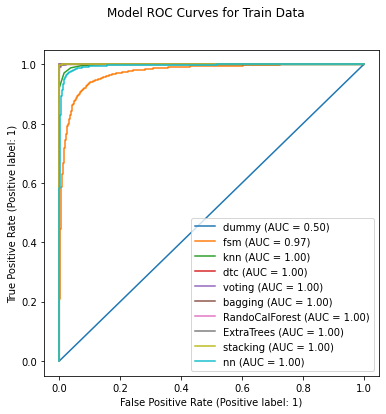

In [61]:
model_dict.plot_models_roc_curves()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


2/2 - 0s - 21ms/epoch - 10ms/step


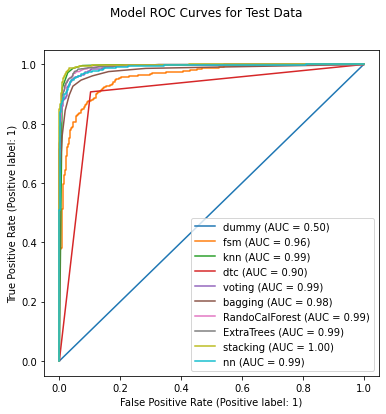

In [62]:
model_dict.plot_models_roc_curves('test')

In [63]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542
0,knn,train,accuracy_score,0.975900
4,knn,test,accuracy_score,0.971084
0,dtc,train,accuracy_score,1.000000
4,dtc,test,accuracy_score,0.902410
0,voting,train,accuracy_score,0.995180
4,voting,test,accuracy_score,0.949398


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


7/7 - 0s - 42ms/epoch - 6ms/step


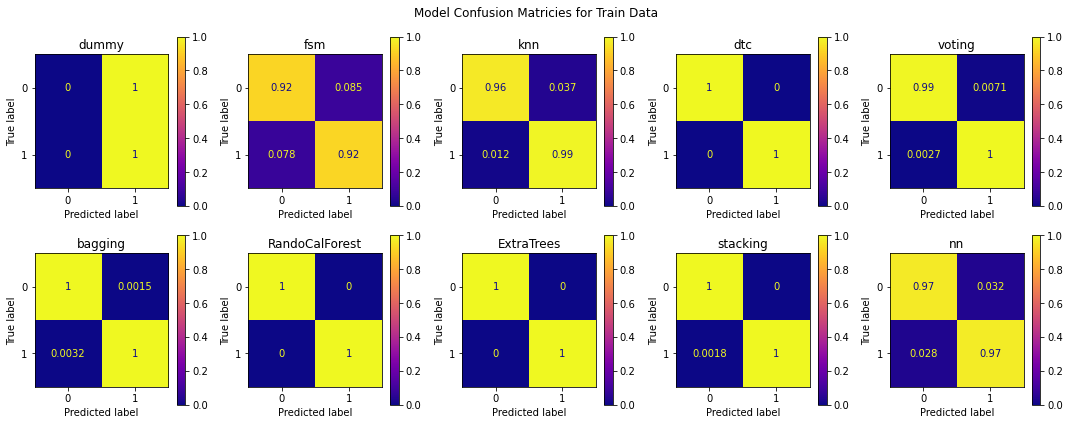

In [64]:
model_dict.plot_models_confusion_matricies()

## Tuning and with `RandomizedSearchCV`

In [ ]:
# rf_pipe = Pipeline([
#     ('ct',CT),
#     ('rf',rf)
# ])

In [66]:
rf_pipe = Pipeline([
    ('rf',rf)
])

In [67]:
rf_pipe

Pipeline(steps=[('rf', RandomForestClassifier(random_state=42, verbose=1))])

In [104]:
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'rf__n_estimators': randint(4,200),
    
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'rf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'rf__min_samples_split': uniform(0.01, 0.199)
}

In [105]:
model_params


{'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x231323f27f0>,
 'rf__max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x2313242b700>,
 'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x231323f2700>}

In [114]:
rgs=RandomizedSearchCV(rf_pipe,
                       model_params,
                       random_state=42,
                       verbose=2,
                       n_iter=10,
                       n_jobs=-1)

In [115]:
# 11min run time!
rgs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s


RandomizedSearchCV(estimator=Pipeline(steps=[('rf',
                                              RandomForestClassifier(random_state=42,
                                                                     verbose=1))]),
                   n_jobs=-1,
                   param_distributions={'rf__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002313242B700>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000231323F2700>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000231323F27F0>},
                   random_state=42, verbose=2)

In [ ]:
# Data 1
# {'rf__max_features': 0.29359252905971395,
#  'rf__min_samples_split': 0.11402383304701681,
#  'rf__n_estimators': 18}

In [116]:
rgs.best_params_

{'rf__max_features': 0.2789523710972579,
 'rf__min_samples_split': 0.03843049676646622,
 'rf__n_estimators': 134}

In [ ]:
# Data 2 n_iter=50
# {'rf__max_features': 0.26338715088042397,
#  'rf__min_samples_split': 0.021558638821471694,
#  'rf__n_estimators': 91}

In [106]:
rgs_best = rgs.best_estimator_

In [ ]:
rgs_best.score(X_train,y_train)

In [ ]:
rgs_best.score(X_test, y_test)

In [76]:
# Data 1
# rgs_best = RandomForestClassifier(max_features=0.29359252905971395,
#                                   min_samples_split = 0.11402383304701681,
#                                   n_estimators = 18)

In [ ]:
# rgs_pipe = Pipeline([('ct', CT), ('rgs', rgs_best)])

In [107]:
rgs_pipe = Pipeline([('rgs', rgs_best)])

In [108]:
rgs_results = SaveModel(model=rgs_pipe, 
                          model_name='rgs',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [109]:
rgs_results.score_model_train_test()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [110]:
model_dict.add_model(rgs_results)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


7/7 - 0s - 73ms/epoch - 10ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


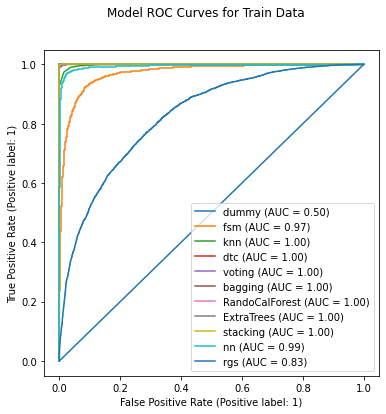

In [111]:
model_dict.plot_models_roc_curves()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


2/2 - 0s - 30ms/epoch - 15ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


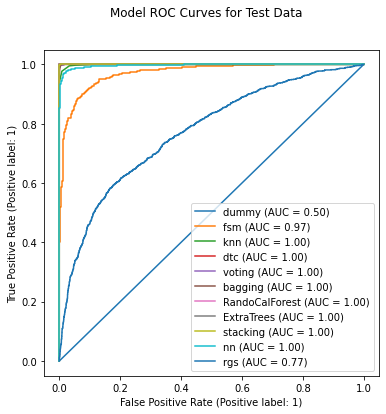

In [112]:
model_dict.plot_models_roc_curves('test')

In [113]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542
0,knn,train,accuracy_score,0.975900
4,knn,test,accuracy_score,0.971084
0,dtc,train,accuracy_score,1.000000
4,dtc,test,accuracy_score,0.902410
0,voting,train,accuracy_score,0.995180
4,voting,test,accuracy_score,0.949398


In [84]:
model_dict.validate_models()

[Voting] ....................... (1 of 3) Processing lr, total=   2.5s
[Voting] ....................... (2 of 3) Processing dt, total=   1.8s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Epoch 1/50
9/9 - 0s - loss: 0.6791 - accuracy: 0.6074 - 491ms/epoch - 55ms/step
Epoch 2/50
9/9 - 0s - loss: 0.6231 - accuracy: 0.7327 - 61ms/epoch - 7ms/step
Epoch 3/50
9/9 - 0s - loss: 0.5533 - accuracy: 0.7911 - 52ms/epoch - 6ms/step
Epoch 4/50
9/9 - 0s - loss: 0.4853 - accuracy: 0.8397 - 56ms/epoch - 6ms/step
Epoch 5/50
9/9 - 0s - loss: 0.4240 - accuracy: 0.8634 - 49ms/epoch - 5ms/step
Epoch 6/50
9/9 - 0s - loss: 0.3715 - accuracy: 0.8773 - 50ms/epoch - 6ms/step
Epoch 7/50
9/9 - 0s - loss: 0.3292 - accuracy: 0.8828 - 79ms/epoch - 9ms/step
Epoch 8/50
9/9 - 0s - loss: 0.2990 - accuracy: 0.8899 - 56ms/epoch - 6ms/step
Epoch 9/50
9/9 - 0s - loss: 0.2813 - accuracy: 0.8931 - 54ms/epoch - 6ms/step
Epoch 10/50
9/9 - 0s - loss: 0.2638 - accuracy: 0.8970 - 45ms/epoch - 5ms/step
Epoch 11/50
9/9 - 0s - loss: 0.2525 - accuracy: 0.9030 - 46ms/epoch - 5ms/step
Epoch 12/50
9/9 - 0s - loss: 0.2416 - accuracy: 0.9055 - 48ms/epoch - 5ms/step
Epoch 13/50
9/9 - 0s - loss: 0.2310 - accuracy: 0.9136 - 44

In [85]:
model_dict.print_scores('accuracy_score')

,model,dataset,metric,value
0,dummy,train,accuracy_score,0.510619
4,dummy,test,accuracy_score,0.501807
0,fsm,train,accuracy_score,0.918512
4,fsm,test,accuracy_score,0.885542
0,knn,train,accuracy_score,0.975900
4,knn,test,accuracy_score,0.971084
0,dtc,train,accuracy_score,1.000000
4,dtc,test,accuracy_score,0.902410
0,voting,train,accuracy_score,0.995180
4,voting,test,accuracy_score,0.949398


In [86]:
results_df  = model_dict.return_scores()

## NN Tuning

This is stolen from [here](https://adriangb.com/scikeras/refs/heads/master/notebooks/Basic_Usage.html)

[Here](https://github.com/tblatrille/Keras_GridSearch/tree/main) is a way to tune deeper into your NN.

In [21]:
X_train.shape

(19920, 23)

In [117]:
def build_model(nbr_features=784):
    
    model = Sequential()
    
    model.add(Input(nbr_features))
    
    model.add(Dense(units=12, activation='relu'))
    
    model.add(Dropout(.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'])
    

    return model

In [33]:
# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='loss', 
                           min_delta=1e-4,
                           verbose=1,
                           patience=5,
                           mode='min')

keras_model = KerasClassifier(build_model,
                              verbose=2,
                              callbacks = [early_stop])

In [34]:
nn_gs_pipe = Pipeline([('nn', keras_model)])

In [35]:
param_grid = {
    'nn__epochs': [10, 20, 30],
    'nn__batch_size':[2, 16, 32],
    'nn__optimizer':['Adam', 'sgd']
}


In [38]:
nn_gs = GridSearchCV(nn_gs_pipe, param_grid, verbose=2, return_train_score=True, n_jobs=3, cv=3)

In [39]:
# 5 hour fit time!
grid_result = nn_gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/10
1245/1245 - 12s - loss: 379.4944 - accuracy: 0.7137 - 12s/epoch - 10ms/step
Epoch 2/10
1245/1245 - 4s - loss: 0.6599 - accuracy: 0.7768 - 4s/epoch - 3ms/step
Epoch 3/10
1245/1245 - 4s - loss: 0.5671 - accuracy: 0.7769 - 4s/epoch - 3ms/step
Epoch 4/10
1245/1245 - 4s - loss: 0.5644 - accuracy: 0.7773 - 4s/epoch - 3ms/step
Epoch 5/10
1245/1245 - 4s - loss: 0.5841 - accuracy: 0.7768 - 4s/epoch - 3ms/step
Epoch 6/10
1245/1245 - 4s - loss: 0.5660 - accuracy: 0.7768 - 4s/epoch - 3ms/step
Epoch 7/10
1245/1245 - 4s - loss: 0.7019 - accuracy: 0.7772 - 4s/epoch - 3ms/step
Epoch 8/10
1245/1245 - 4s - loss: 0.5750 - accuracy: 0.7774 - 4s/epoch - 3ms/step
Epoch 9/10
1245/1245 - 4s - loss: 0.6979 - accuracy: 0.7769 - 4s/epoch - 3ms/step
Epoch 00009: early stopping


In [ ]:
# {'nn__batch_size': 16, 'nn__epochs': 10, 'nn__optimizer': 'sgd'}

In [52]:
early_stop = EarlyStopping(monitor='loss', 
                           min_delta=1e-4,
                           verbose=1,
                           patience=5,
                           mode='min')

best_nn = KerasClassifier(build_model,
                              verbose=2,
                              batch_size=16,
                              epochs=10,
                              optimizer='sgd',
                              callbacks = [early_stop])

In [53]:
nn_gs_results = SaveModel(model=best_nn, 
                          model_name='best_nn',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test,
                          X_tt=X_tt,
                          y_tt=y_tt,
                          X_val=X_val,
                          y_val=y_val)

In [54]:
nn_gs_results.score_model_train_test()

Epoch 1/10
1245/1245 - 4s - loss: 503.0487 - accuracy: 0.7413 - 4s/epoch - 3ms/step
Epoch 2/10
1245/1245 - 3s - loss: 3.9017 - accuracy: 0.7740 - 3s/epoch - 3ms/step
Epoch 3/10
1245/1245 - 4s - loss: 2.0705 - accuracy: 0.7767 - 4s/epoch - 3ms/step
Epoch 4/10
1245/1245 - 3s - loss: 0.8834 - accuracy: 0.7779 - 3s/epoch - 3ms/step
Epoch 5/10
1245/1245 - 3s - loss: 0.7484 - accuracy: 0.7778 - 3s/epoch - 3ms/step
Epoch 6/10
1245/1245 - 3s - loss: 0.7587 - accuracy: 0.7779 - 3s/epoch - 3ms/step
Epoch 7/10
1245/1245 - 3s - loss: 0.8852 - accuracy: 0.7778 - 3s/epoch - 3ms/step
Epoch 8/10
1245/1245 - 3s - loss: 0.6012 - accuracy: 0.7779 - 3s/epoch - 3ms/step
Epoch 9/10
1245/1245 - 4s - loss: 1.1667 - accuracy: 0.7778 - 4s/epoch - 3ms/step
Epoch 10/10
1245/1245 - 4s - loss: 0.6706 - accuracy: 0.7778 - 4s/epoch - 3ms/step
1245/1245 - 1s - 1s/epoch - 933us/step
312/312 - 0s - 393ms/epoch - 1ms/step


E:\python-envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\python-envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
model_dict.add_model(nn_gs_results)

NameError: name 'model_dict' is not defined

In [ ]:
model_dict.plot_models_roc_curves()

In [ ]:
model_dict.plot_models_roc_curves('test')

In [ ]:
model_dict.print_scores('accuracy_score')

In [ ]:
results_df  = model_dict.return_scores()